<a href="https://colab.research.google.com/github/airbytehq/quickstarts/blob/master/pyairbyte_notebooks/PyAirbyte_Github_Incremental_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this demo, we use PyAirbyte to extract data from Github, followed by a series of transformations and analyses to derive meaningful insights from this data. In particular, we demonstrate PyAirbyte capabilities for extracting data incrementally.

#### Prerequisites:

-   A Github personal access token. For details on configuring authetication credentials, refer to the Github source connector [documentation](https://docs.airbyte.com/integrations/sources/github).


In [ ]:
# Add virtual environment support in Google Colab
!apt-get install -qq python3.10-venv

# Install airbyte
%pip install --quiet airbyte

### Load source data from Github to local cache

In this section, we establish a connection to Github via PyAirbyte. The source connector is configured with necessary parameters like the credentials repository we are interested in. Check the [docs](https://docs.airbyte.com/integrations/sources/github) for more details on these parameters.

After configuring the source connector, we perform a `check()` to ensure that the configuration is correct and the connection to the API is successful. Then, we list the available streams for this source and select the ones we are interested in syncing.

Then, we proceed to read from the source into the internal DuckDB cache.

Note: The credentials are retrieved securely using the `get_secret()` method. This will automatically locate a matching Google Colab secret or environment variable, ensuring they are not hard-coded into the notebook. Make sure to add your key to the Secrets section on the left.


In [ ]:
import airbyte as ab

# Create and configure the source:
source = ab.get_source(
    "source-github",
    install_if_missing=True,
    config={
        "repositories": ["airbytehq/quickstarts"],
        "credentials": {
            "personal_access_token": ab.get_secret("GITHUB_PERSONAL_ACCESS_TOKEN"),
        },
    },
)

# Verify the config and creds by running `check`:
source.check()

Installing 'source-github' into virtual environment '/content/.venv-source-github'.
Running 'pip install airbyte-source-github'...

Connector 'source-github' installed successfully!
For more information, see the source-github documentation:
https://docs.airbyte.com/integrations/sources/github#reference

Connection check succeeded for `source-github`.

In [ ]:
# List the available streams available for the Github source
source.get_available_streams()

['issue_timeline_events',
 'assignees',
 'branches',
 'collaborators',
 'comments',
 'commit_comment_reactions',
 'commit_comments',
 'commits',
 'contributor_activity',
 'deployments',
 'events',
 'issue_comment_reactions',
 'issue_events',
 'issue_labels',
 'issue_milestones',
 'issue_reactions',
 'issues',
 'organizations',
 'project_cards',
 'project_columns',
 'projects',
 'pull_request_comment_reactions',
 'pull_request_commits',
 'pull_request_stats',
 'projects_v2',
 'pull_requests',
 'releases',
 'repositories',
 'review_comments',
 'reviews',
 'stargazers',
 'tags',
 'teams',
 'team_members',
 'users',
 'workflows',
 'workflow_runs',
 'workflow_jobs',
 'team_memberships']

In [ ]:
# Select the streams we are interested in loading to cache
source.set_streams(["pull_requests", "issues", "reviews", "stargazers"])

# Read into DuckDB local default cache
cache = ab.get_default_cache()
result = source.read(cache=cache)

## Read Progress

Started reading at 22:16:25.

Read **314** records over **6 seconds** (52.3 records / second).

Wrote **314** records over 4 batches.

Finished reading at 22:16:32.

Started finalizing streams at 22:16:32.

Finalized **4** batches over 2 seconds.

Completed 4 out of 4 streams:

  - reviews
  - stargazers
  - pull_requests
  - issues


Completed writing at 22:16:34. Total time elapsed: 8 seconds


------------------------------------------------


Completed `source-github` read operation at 22:16:34.

### Read again to sync changes

The PyAirbyte Github source connector has the ability to read data incrementally by default, meaning that after the first successful data sync, only updates and new records will be synced in subsequent reads.

For more information on sync modes for this source, you can refer to the [docs](https://docs.airbyte.com/integrations/sources/github).

Let's read again, and see how no records will be loaded to cache.


In [ ]:
result = source.read(cache=cache)

## Read Progress

Started reading at 22:17:30.

Read **0** records over **3 seconds** (0.0 records / second).

Finished reading at 22:17:33.

Started finalizing streams at 22:17:33.

Finalized **0** batches over 0 seconds.

Completed 4 out of 4 streams:

  - reviews
  - stargazers
  - pull_requests
  - issues


Completed writing at 22:17:33. Total time elapsed: 3 seconds


------------------------------------------------


Completed `source-github` read operation at 22:17:33.

### Read data from the cache

Read from the already-written DuckDB cache into a pandas Dataframe. After the data is in the cache, you can read it without re-configuring or re-creating the source object. You can also select a specific stream to read from.


In [ ]:
# Read from the cache into a pandas Dataframe:
reviews = cache["reviews"].to_pandas()
stargazers = cache["stargazers"].to_pandas()
pull_requests = cache["pull_requests"].to_pandas()
issues = cache["issues"].to_pandas()

### Transform and analyze the data

Let's take our Github data and run some analysis with `pandas` and `matplotlib`.


In [ ]:
reviews.head(3)

,repository,id,node_id,user,body,state,html_url,pull_request_url,_links,submitted_at,created_at,updated_at,commit_id,author_association
0,airbytehq/quickstarts,1689913150,PRR_kwDOKQqr2s5kugc-,{'avatar_url': https://avatars.githubuserconte...,,COMMENTED,https://github.com/airbytehq/quickstarts/pull/...,https://github.com/airbytehq/quickstarts/pull/59,{'html': {'href': https://github.com/airbytehq...,2023-10-20 12:18:17,2023-10-20 12:18:17,2023-10-20 12:18:17,29ca06ae449b07f17c1be6bb104264b6d62dafcc,MEMBER
1,airbytehq/quickstarts,1689921852,PRR_kwDOKQqr2s5kuik8,{'avatar_url': https://avatars.githubuserconte...,,COMMENTED,https://github.com/airbytehq/quickstarts/pull/...,https://github.com/airbytehq/quickstarts/pull/59,{'html': {'href': https://github.com/airbytehq...,2023-10-20 12:23:23,2023-10-20 12:23:22,2023-10-20 12:23:23,29ca06ae449b07f17c1be6bb104264b6d62dafcc,CONTRIBUTOR
2,airbytehq/quickstarts,1689945893,PRR_kwDOKQqr2s5kuocl,{'avatar_url': https://avatars.githubuserconte...,,COMMENTED,https://github.com/airbytehq/quickstarts/pull/...,https://github.com/airbytehq/quickstarts/pull/59,{'html': {'href': https://github.com/airbytehq...,2023-10-20 12:38:03,2023-10-20 12:38:03,2023-10-20 12:38:03,29ca06ae449b07f17c1be6bb104264b6d62dafcc,CONTRIBUTOR


In [ ]:
stargazers.head(3)

,repository,user_id,starred_at,user
0,airbytehq/quickstarts,95236817,2023-10-02 16:40:52,{'avatar_url': https://avatars.githubuserconte...
1,airbytehq/quickstarts,123734227,2023-10-17 10:50:04,{'avatar_url': https://avatars.githubuserconte...
2,airbytehq/quickstarts,70362748,2023-10-31 02:20:26,{'avatar_url': https://avatars.githubuserconte...


In [ ]:
pull_requests.head(3)

,repository,url,id,node_id,html_url,diff_url,patch_url,issue_url,commits_url,review_comments_url,...,assignee,assignees,requested_reviewers,requested_teams,head,base,_links,author_association,auto_merge,draft
0,airbytehq/quickstarts,https://api.github.com/repos/airbytehq/quickst...,1534111883,PR_kwDOKQqr2s5bcLCL,https://github.com/airbytehq/quickstarts/pull/35,https://github.com/airbytehq/quickstarts/pull/...,https://github.com/airbytehq/quickstarts/pull/...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,...,None,[],[],[],"{'label': airbytehq:ecommerce-analytics-stack,...","{'label': airbytehq:main, 'ref': main, 'repo':...",{'comments': {'href': https://api.github.com/r...,MEMBER,None,false
1,airbytehq/quickstarts,https://api.github.com/repos/airbytehq/quickst...,1534172082,PR_kwDOKQqr2s5bcZuy,https://github.com/airbytehq/quickstarts/pull/36,https://github.com/airbytehq/quickstarts/pull/...,https://github.com/airbytehq/quickstarts/pull/...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,...,None,[],[],[],"{'label': airbytehq:ecommerce-analytics-stack,...","{'label': airbytehq:main, 'ref': main, 'repo':...",{'comments': {'href': https://api.github.com/r...,MEMBER,None,false
2,airbytehq/quickstarts,https://api.github.com/repos/airbytehq/quickst...,1545412143,PR_kwDOKQqr2s5cHR4v,https://github.com/airbytehq/quickstarts/pull/38,https://github.com/airbytehq/quickstarts/pull/...,https://github.com/airbytehq/quickstarts/pull/...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,...,None,[],[],[],{'label': avionmission:feature/pad_bigquery_st...,"{'label': airbytehq:main, 'ref': main, 'repo':...",{'comments': {'href': https://api.github.com/r...,FIRST_TIME_CONTRIBUTOR,None,false


In [ ]:
issues.head(3)

,repository,id,node_id,url,repository_url,labels_url,comments_url,events_url,html_url,number,...,pull_request,closed_at,created_at,updated_at,author_association,draft,reactions,timeline_url,performed_via_github_app,state_reason
0,airbytehq/quickstarts,1917441405,PR_kwDOKQqr2s5bcLCL,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://github.com/airbytehq/quickstarts/pull/35,35,...,{'diff_url': https://github.com/airbytehq/quic...,2023-09-28T12:35:12Z,2023-09-28 12:32:19,2023-09-28 12:35:12,MEMBER,false,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/airbytehq/quickst...,None,None
1,airbytehq/quickstarts,1917507008,PR_kwDOKQqr2s5bcZuy,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://github.com/airbytehq/quickstarts/pull/36,36,...,{'diff_url': https://github.com/airbytehq/quic...,2023-09-28T13:02:56Z,2023-09-28 13:01:48,2023-09-28 13:02:56,MEMBER,false,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/airbytehq/quickst...,None,None
2,airbytehq/quickstarts,1930249843,PR_kwDOKQqr2s5cHR4v,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://api.github.com/repos/airbytehq/quickst...,https://github.com/airbytehq/quickstarts/pull/38,38,...,{'diff_url': https://github.com/airbytehq/quic...,None,2023-10-06 14:04:27,2023-10-12 15:20:21,FIRST_TIME_CONTRIBUTOR,false,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/airbytehq/quickst...,None,None


#### Pull Requests Trend Over Time

This will visualize the number of pull requests created over time.


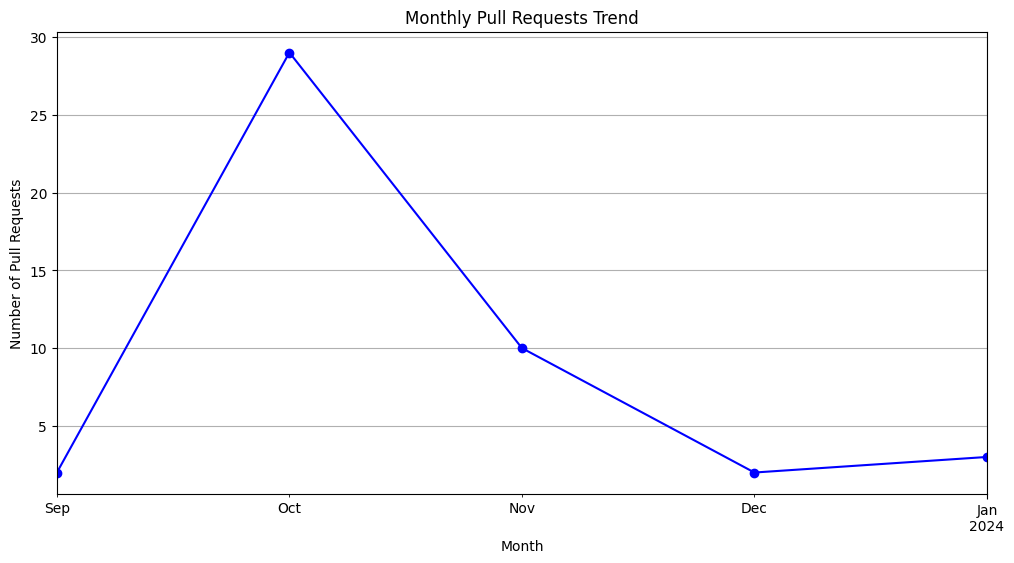

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pull_requests' dataframe is available and has a 'created_at' column in datetime format
pull_requests["created_at"] = pd.to_datetime(pull_requests["created_at"])
pr_trend = pull_requests.resample("M", on="created_at").size()

plt.figure(figsize=(12, 6))
pr_trend.plot(kind="line", color="blue", marker="o")
plt.title("Monthly Pull Requests Trend")
plt.xlabel("Month")
plt.ylabel("Number of Pull Requests")
plt.grid(True)
plt.show()

#### Open vs Closed Issues

Compare the number of open versus closed issues.


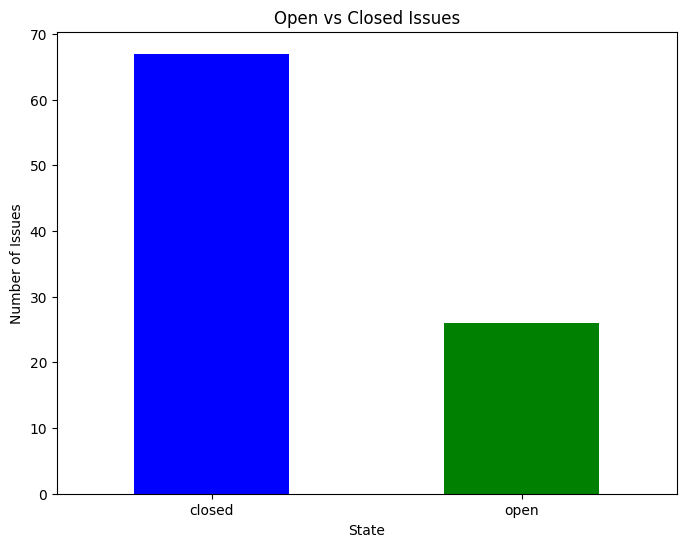

In [ ]:
# Assuming 'issues' dataframe has a 'state' column
issue_status_count = issues["state"].value_counts()

plt.figure(figsize=(8, 6))
issue_status_count.plot(kind="bar", color=["blue", "green"])
plt.title("Open vs Closed Issues")
plt.xlabel("State")
plt.ylabel("Number of Issues")
plt.xticks(rotation=0)
plt.show()

#### Star Growth Over Time

Plot the cumulative count of stars over time.


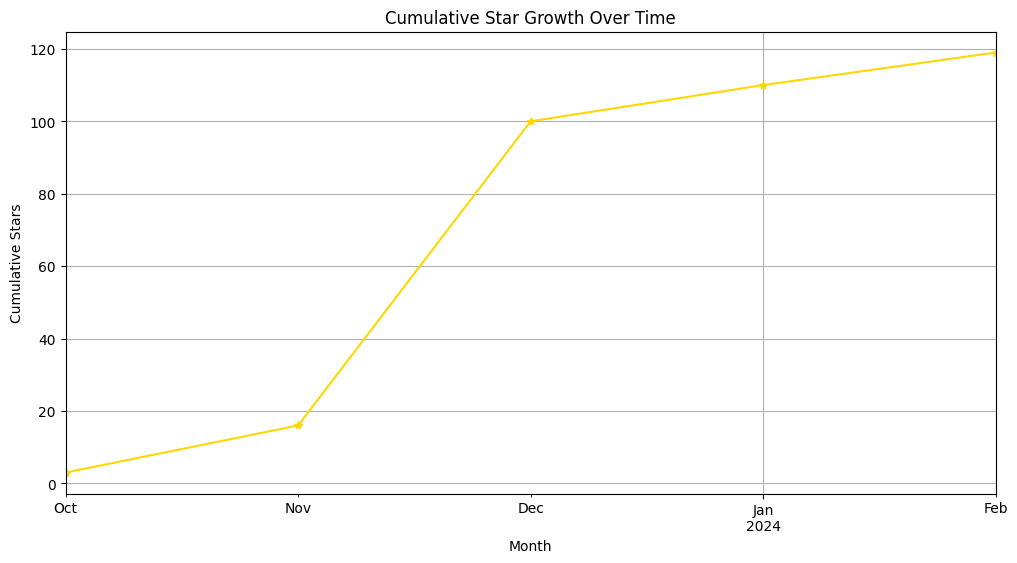

In [ ]:
# Assuming 'stargazers' dataframe has a 'starred_at' column in datetime format
stargazers["starred_at"] = pd.to_datetime(stargazers["starred_at"])
star_growth = stargazers.resample("M", on="starred_at").size().cumsum()

plt.figure(figsize=(12, 6))
star_growth.plot(kind="line", color="gold", marker="*")
plt.title("Cumulative Star Growth Over Time")
plt.xlabel("Month")
plt.ylabel("Cumulative Stars")
plt.grid(True)
plt.show()

#### Issue Resolution Followed by Pull Requests

This analysis checks if there's a trend in issue resolutions followed by pull requests, which might indicate active development in response to issues.


In [ ]:
# Convert created_at and closet_at to datetime
pull_requests["created_at"] = pd.to_datetime(pull_requests["created_at"])
issues["closed_at"] = issues["closed_at"].dt.tz_localize(None)

# Resample both dataframes to get monthly counts
monthly_closed_issues = issues.resample("M", on="closed_at").size()
monthly_created_prs = pull_requests.resample("M", on="created_at").size()

# Combine into a single dataframe
combined_issues_prs_df = pd.concat([monthly_closed_issues, monthly_created_prs], axis=1)
combined_issues_prs_df.columns = ["Monthly Closed Issues", "Monthly Created PRs"]

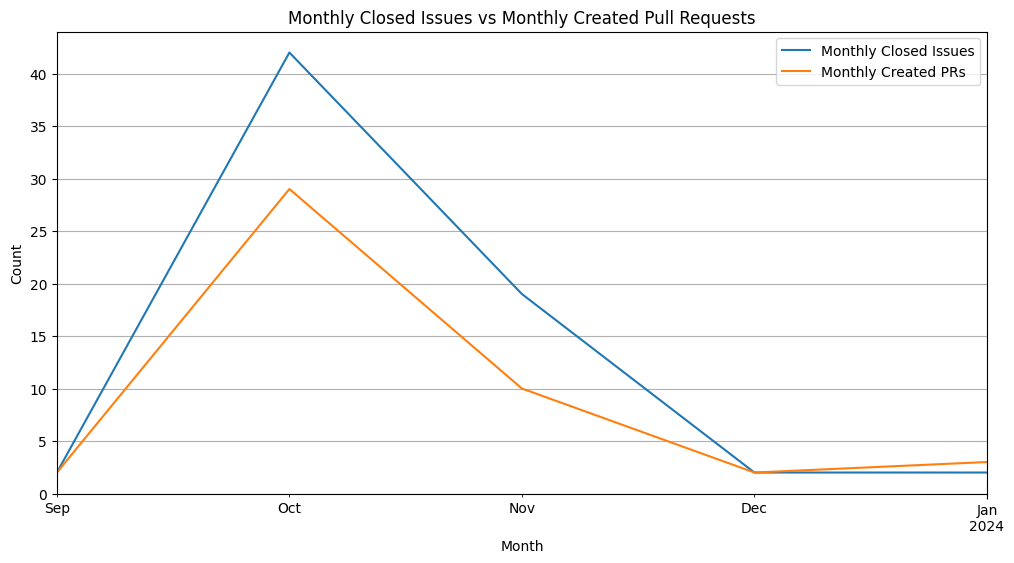

In [ ]:
combined_issues_prs_df.plot(kind="line", figsize=(12, 6))
plt.title("Monthly Closed Issues vs Monthly Created Pull Requests")
plt.xlabel("Month")
plt.ylabel("Count")
plt.grid(True)
plt.show()